In [1]:
from pathlib import Path
import itertools
import re
import csv
import torch
import numpy as np
from scipy import ndimage
import os
import nibabel as nib
import matplotlib.pyplot as plt
from monai.transforms import CropForeground, ScaleIntensity
from tqdm.notebook import tqdm

In [3]:
CLASS_NAMES = [ 'CN', 'AD']
DATA_DIR = '/hdd/Polygence/Data/OASIS/original_mri_data/'
# SAVE_DIR = './NumpyOrigOASIS'

# os.mkdir(SAVE_DIR)
# for clas in CLASS_NAMES:
#     os.mkdir(SAVE_DIR+'/'+clas)

### Get filenames

In [4]:
files = list(Path(DATA_DIR).rglob("*nii.gz"))
print(len(files))

3388


In [5]:
temp_files = {}
for key, group in itertools.groupby(sorted(files), lambda i: re.search('OAS\d+_MR_d\d+', str(i)).group()):
    temp_files[key] = sorted(list(group), key=lambda x: len(str(x)))[0]
print(len(temp_files))

2161


In [6]:
temp_names = list(temp_files.keys())
print(len(temp_names))

2161


In [7]:
# # There are multiple different types of shapes, of which the (256,256,128) one is not compatible
# shapes = set()
# for img in temp_names:
#     shapes.add(nib.load(temp_files[img]).shape)
# print(shapes)

KeyboardInterrupt: 

In [8]:
# Remove incompatiable scan shapes
image_files = {}

for img in temp_names:
    shape = nib.load(temp_files[img]).shape
    if shape[0] > shape[2]:
        continue
    else:
        image_files[img] = temp_files[img]
    image_files[img] = temp_files[img]
        
print(len(image_files))

1969


In [9]:
image_names = list(image_files.keys())
print(len(image_names))

1969


In [10]:
shapes = set()
for img in image_names:
    shapes.add(nib.load(image_files[img]).shape)
print(shapes)

{(160, 224, 256), (160, 256, 256), (160, 240, 256), (176, 256, 256), (176, 240, 256)}


In [11]:
labels = {}
with open(os.path.join(DATA_DIR, '..', 'orig.csv'), 'r') as file:
    reader = csv.reader(file)
    index = 0
    for row in reader:
        if index != 0 and row[0] in image_names:
            pat_type = "CN" if row[2] == "Cognitively normal" else "AD"
            labels[row[0]] = pat_type
        index += 1

print(len(labels))

for item in list(labels.keys())[:5]:
    print(item, labels[item])

1969
OAS30001_MR_d0129 CN
OAS30001_MR_d0757 CN
OAS30001_MR_d2430 CN
OAS30001_MR_d3132 CN
OAS30002_MR_d0371 CN


In [12]:
def show_scan(img, img_name=None):
    fig, ax = plt.subplots(1, 3, figsize=(20,7))
    print(img.shape)
    
    if img_name != None:
        fig.suptitle(f'{img_name}, {labels[img_name]}')
    
    if len(img.shape) == 3:
        depth, width, height = img.shape
        ax[0].imshow(img[depth//2, :, :])
        ax[1].imshow(img[:, width//2, :])
        ax[2].imshow(img[:, :, height//2])
    else:
        _, depth, width, height = img.shape
        ax[0].imshow(img[0, depth//2, :, :])
        ax[1].imshow(img[0, :, width//2, :])
        ax[2].imshow(img[0, :, :, height//2])
    
    plt.show()

In [13]:
files = list(Path('/home/jack/Code/GitHub/Polygence/transfer/Alzheimer-ResNets/NumpyADNI/').rglob("*np"))
min_val = 100000
max_val = -30
max_scan = None
min_scan = None
for file in tqdm(files):
    img = np.load(file, allow_pickle=True)[0]
    min_img = img.min()
    max_img = img.max()
    
    if min_img < min_val:
        min_val = min_img
        min_scan = file
    
    if max_img > max_val:
        max_val = max_img
        max_scan = file

  0%|          | 0/5375 [00:00<?, ?it/s]

In [14]:
# Gives us a reference to aim for in the OASIS scans
print(min_val, max_val)

-1.0 31.117645


(1, 87, 75, 100)


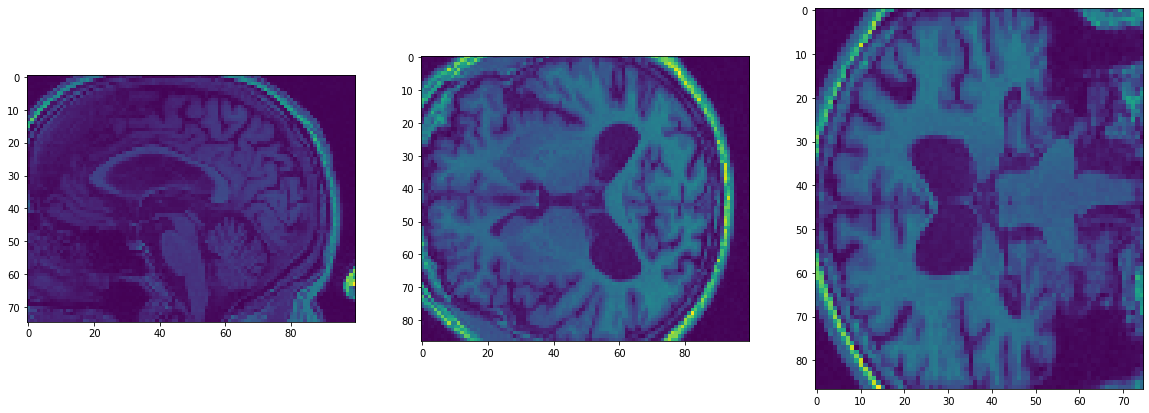

[0 0 0 0 1]


In [15]:
show_scan(np.load(max_scan, allow_pickle=True)[0])
print(np.load(max_scan, allow_pickle=True)[1])

(1, 87, 75, 100)


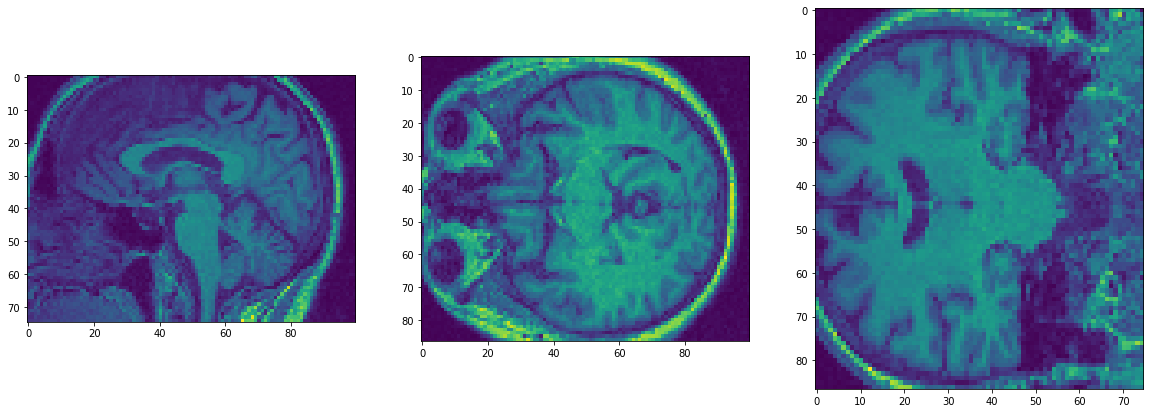

[0 0 0 1 0]


In [16]:
show_scan(np.load(min_scan, allow_pickle=True)[0])
print(np.load(min_scan, allow_pickle=True)[1])

In [16]:
def transforms(image, num_slices=256, cut=(slice(40,214,2),slice(50,200,2),slice(40,240,2))):
    
    # Make sure it's an ndarray and float32
    image = np.array(image).astype("float32")
    
    # Swap the dimensions
    image = np.flip(image.transpose(0, 2, 1))
    
    # Normalize the image
    image = 2*image/255-1
    
    # Resize to 256x256x256
    (deep, height, width) = image.shape
    if height > width:
        w = (height-width)//2
        for i in range(w):
            image = np.insert(image, width, [0], axis=2)
        for i in range(w):
            image = np.insert(image, 0, [0], axis=2)
    if height < width:
        h = (width-height)//2
        for i in range(h):
            image = np.insert(image, width, [0], axis=1)
        for i in range(w):
            image = np.insert(image, 0, [0], axis=1)
    if image.shape[1] != 256 and image.shape[2] != 256:
        real_resize_factor = np.array([deep, 256, 256]) / image.shape
        image = ndimage.interpolation.zoom(image, real_resize_factor, order=1)
    if num_slices is not None:            
        (deep, height, width) = image.shape
        if num_slices != deep:
            real_resize_factor = np.array([num_slices, height, width]) / image.shape
            image = ndimage.interpolation.zoom(image, real_resize_factor, order=1)
    
    # Crop the image
    image = image[cut[0], cut[1], cut[2]]
    
    return image

min: -1.0, max: 4.302729606628418
(87, 75, 100)


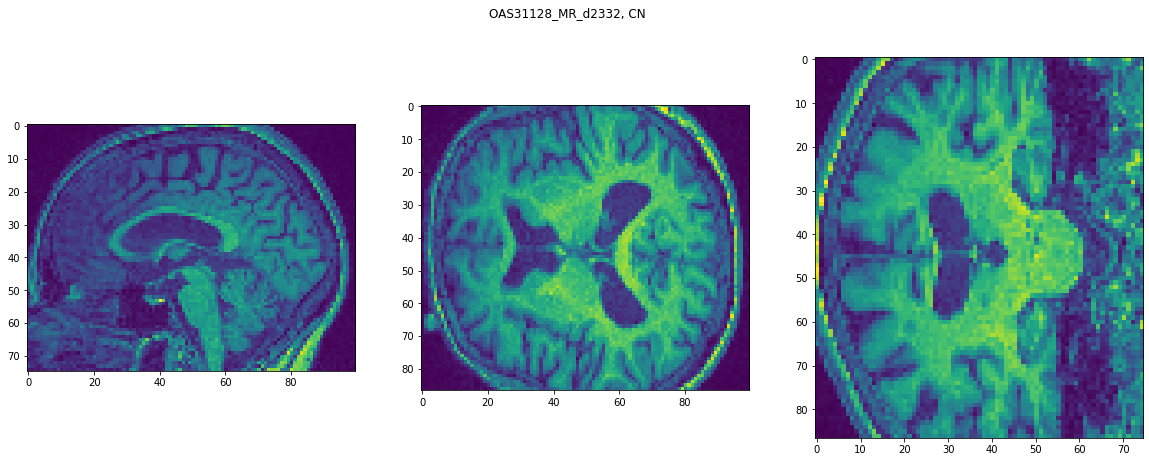

min: -1.0, max: 4.154479026794434
(87, 75, 100)


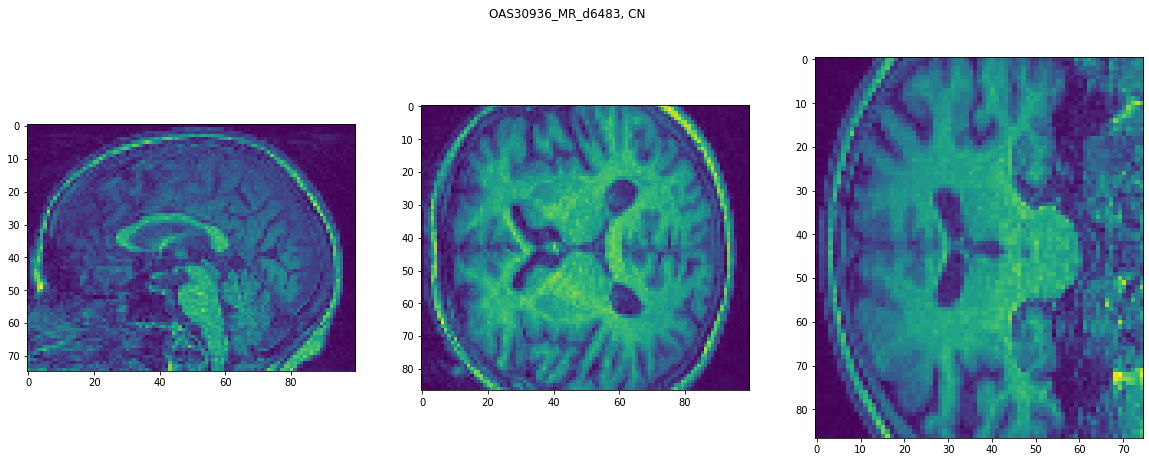

min: -1.0, max: 9.148250579833984
(87, 75, 100)


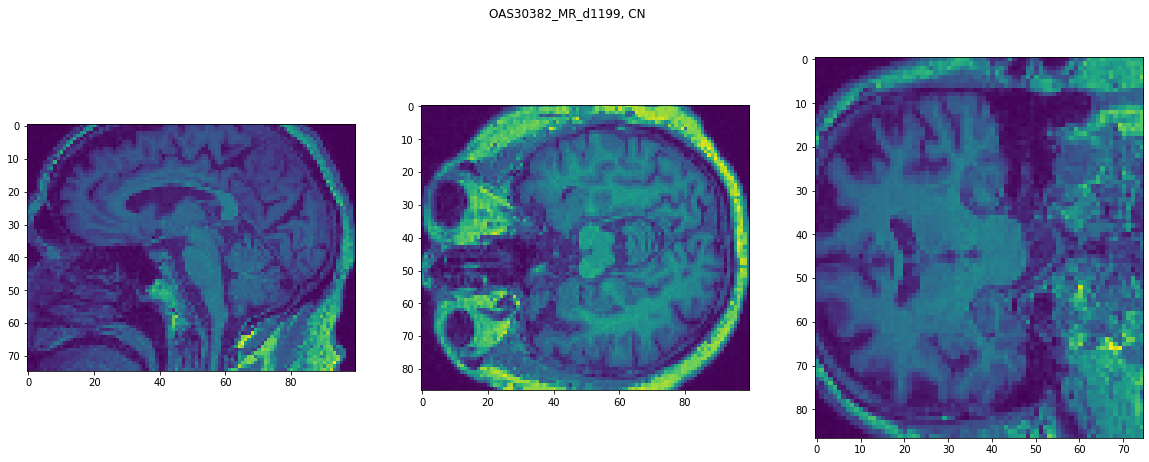

min: -1.0, max: 4.602768421173096
(87, 75, 100)


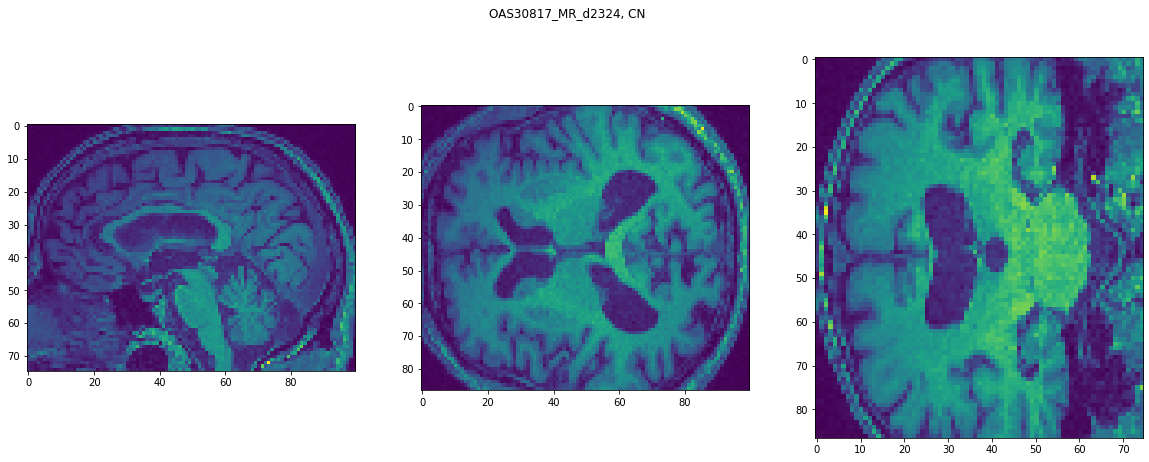

min: -1.0, max: 4.226451396942139
(87, 75, 100)


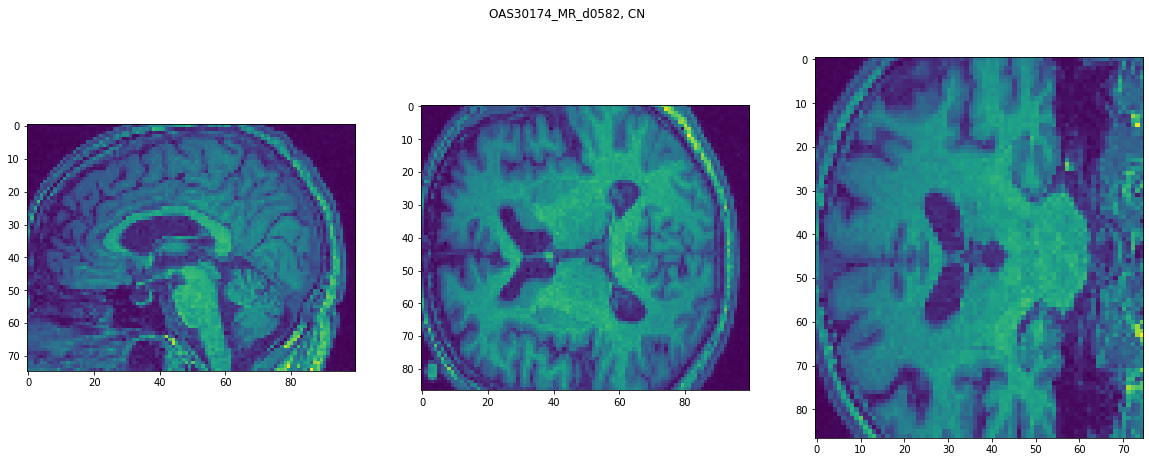

In [17]:
for img in np.random.choice(image_names, size=(5)):
    test_image = nib.load(image_files[img]).get_fdata()
    test_image = transforms(test_image)
    print(f'min: {test_image.min()}, max: {test_image.max()}')
    show_scan(test_image, img)

In [18]:
from IPython import display as dspl
import ipywidgets as widgets

# graphs the MRI image
def show_graph(img, height, width, depth):
    # Plots brain scans in all three dimensions
    fig, ax = plt.subplots(1, 3, figsize=(15,7))
    print(img.shape)
    
    if len(img.shape) == 3:
        ax[0].imshow(img[height, :, :])
        ax[1].imshow(np.rot90(img[:, width, :]))
        ax[2].imshow(np.rot90(img[:, :, depth], 3))
    else:
        ax[0].imshow(img[0, height, :, :])
        ax[1].imshow(np.rot90(img[0, :, width, :]))
        ax[2].imshow(np.rot90(img[0, :, :, depth], 3))
    

def disp(image_data):
    if len(image_data.shape) == 3:
        height, width, depth  = image_data.shape
    else:
        _, height, width, depth  = image_data.shape
    hi = widgets.IntSlider(value=height/2, max=height-1, continous_updates=False, description='View 1')
    wi = widgets.IntSlider(value=width/2, max=width-1, continous_updates=False, description='View 2')
    de = widgets.IntSlider(value=depth/2, max=depth-1, continous_updates=False, description='View 3')
    ui = widgets.HBox([hi, wi, de])
    
    display_output = widgets.interactive_output(show_graph, {'img':widgets.fixed(image_data),
                                                             'height':hi,
                                                             'width':wi,
                                                             'depth':de})
    dspl.display(ui, display_output)

In [19]:
disp(test_image)

Output()

In [20]:
disp(np.load(min_scan, allow_pickle=True)[0])

Output()

In [21]:
CLASS_NAMES = ['CN', 'MCI', 'AD']

In [22]:
print(np.unique(list(labels.values())))

['AD' 'CN']


In [23]:
from collections import defaultdict

shapes = defaultdict(list)

In [24]:
files = 0
def process_and_save_image(key):
    global files
    fpath = image_files[key]
    image = nib.load(fpath).get_fdata()
    
    image = transforms(image)
    
    label = []
    for c in CLASS_NAMES:
        if c == labels[key]:
            label.append(1)
        else:
            label.append(0)
            
#     print(f'Now saving image for subject {key}, sized {str(image.shape)}, with label of {label}')
#     print(f'Original path was {fpath}')
    shapes[str(image.shape)].append(fpath)

    filename = SAVE_DIR+'/'+labels[key]+'/'+key+'.np'
    with open(filename, 'wb') as file:
#         print(f'Saving to path {filename}')
        np.save(file, np.array([np.array([image]), np.array(label)], dtype=object))
        files += 1
        file.close()
#     print('-'*60)

In [25]:
# from multiprocessing import Pool

# pool = Pool(os.cpu_count())
# pool.map(process_and_save_image, image_names)
# res = list(tqdm(pool.imap(process_and_save_image, image_names), total=30))

In [26]:
from tqdm.contrib.concurrent import thread_map
res = thread_map(process_and_save_image, image_names, max_workers=16)

  0%|          | 0/1969 [00:00<?, ?it/s]

In [27]:
print(f'Total files: {files}')

Total files: 1969


In [28]:
print(shapes.keys())

dict_keys(['(87, 75, 100)'])


In [29]:
len(list(Path('/home/jack/Code/GitHub/Polygence/transfer/Alzheimer-ResNets/NumpyOrigOASIS').rglob("*.np")))

1969